Using device: cpu
Loading MNIST dataset...
Dataset loaded successfully!
Starting training...
Epoch 1/20:
Training Loss: 1.0471
Test Loss: 0.2906
Test Accuracy: 0.9155

Epoch 2/20:
Training Loss: 0.2333
Test Loss: 0.1679
Test Accuracy: 0.9495

Epoch 3/20:
Training Loss: 0.1531
Test Loss: 0.1187
Test Accuracy: 0.9633

Epoch 4/20:
Training Loss: 0.1137
Test Loss: 0.0959
Test Accuracy: 0.9718

Epoch 5/20:
Training Loss: 0.0912
Test Loss: 0.0748
Test Accuracy: 0.9758

Epoch 6/20:
Training Loss: 0.0746
Test Loss: 0.0774
Test Accuracy: 0.9754

Epoch 7/20:
Training Loss: 0.0644
Test Loss: 0.0604
Test Accuracy: 0.9799

Epoch 8/20:
Training Loss: 0.0566
Test Loss: 0.0524
Test Accuracy: 0.9819

Epoch 9/20:
Training Loss: 0.0516
Test Loss: 0.0570
Test Accuracy: 0.9816

Epoch 10/20:
Training Loss: 0.0454
Test Loss: 0.0482
Test Accuracy: 0.9851

Epoch 11/20:
Training Loss: 0.0420
Test Loss: 0.0429
Test Accuracy: 0.9857

Epoch 12/20:
Training Loss: 0.0389
Test Loss: 0.0426
Test Accuracy: 0.9855

Epoc

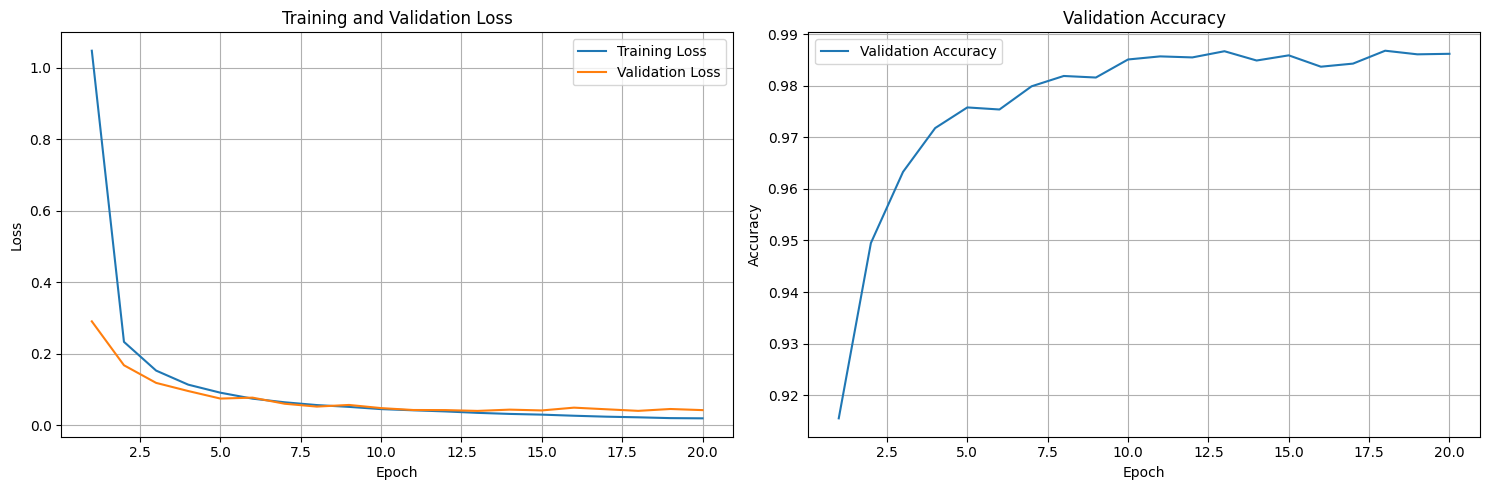

In [13]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 确保使用 GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 定义 LeNet 模型
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # 第一个卷积块
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 第二个卷积块
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Xavier初始化
        self._initialize_weights()

    def forward(self, x):
        # 使用sigmoid激活函数
        x = torch.sigmoid(self.conv1(x))
        x = self.avg_pool1(x)

        x = torch.sigmoid(self.conv2(x))
        x = self.avg_pool2(x)

        x = x.view(x.size(0), -1)

        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)

# 设置随机种子以确保结果可重现
torch.manual_seed(42)

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# 加载MNIST数据集
print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Dataset loaded successfully!")

# 初始化模型、损失函数和优化器
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# 评估函数
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

# 训练过程
epochs = 20
train_losses = []
test_losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}\n')

# 绘制结果
plt.figure(figsize=(15, 5))

# 训练损失和验证损失
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 验证准确率
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# 保存原始LeNet的结果
lenet_train_losses = train_losses.copy()
lenet_test_losses = test_losses.copy()
lenet_accuracies = test_accuracies.copy()

Using device: cpu
Loading MNIST dataset...
Dataset loaded successfully!
Starting training...
Epoch 1/20:
Training Loss: 0.2097
Test Loss: 0.0799
Test Accuracy: 0.9761

Epoch 2/20:
Training Loss: 0.0685
Test Loss: 0.0544
Test Accuracy: 0.9824

Epoch 3/20:
Training Loss: 0.0492
Test Loss: 0.0525
Test Accuracy: 0.9817

Epoch 4/20:
Training Loss: 0.0388
Test Loss: 0.0426
Test Accuracy: 0.9860

Epoch 5/20:
Training Loss: 0.0307
Test Loss: 0.0571
Test Accuracy: 0.9820

Epoch 6/20:
Training Loss: 0.0270
Test Loss: 0.0477
Test Accuracy: 0.9854

Epoch 7/20:
Training Loss: 0.0219
Test Loss: 0.0334
Test Accuracy: 0.9900

Epoch 8/20:
Training Loss: 0.0192
Test Loss: 0.0361
Test Accuracy: 0.9892

Epoch 9/20:
Training Loss: 0.0170
Test Loss: 0.0440
Test Accuracy: 0.9873

Epoch 10/20:
Training Loss: 0.0152
Test Loss: 0.0356
Test Accuracy: 0.9899

Epoch 11/20:
Training Loss: 0.0141
Test Loss: 0.0365
Test Accuracy: 0.9892

Epoch 12/20:
Training Loss: 0.0119
Test Loss: 0.0347
Test Accuracy: 0.9902

Epoc

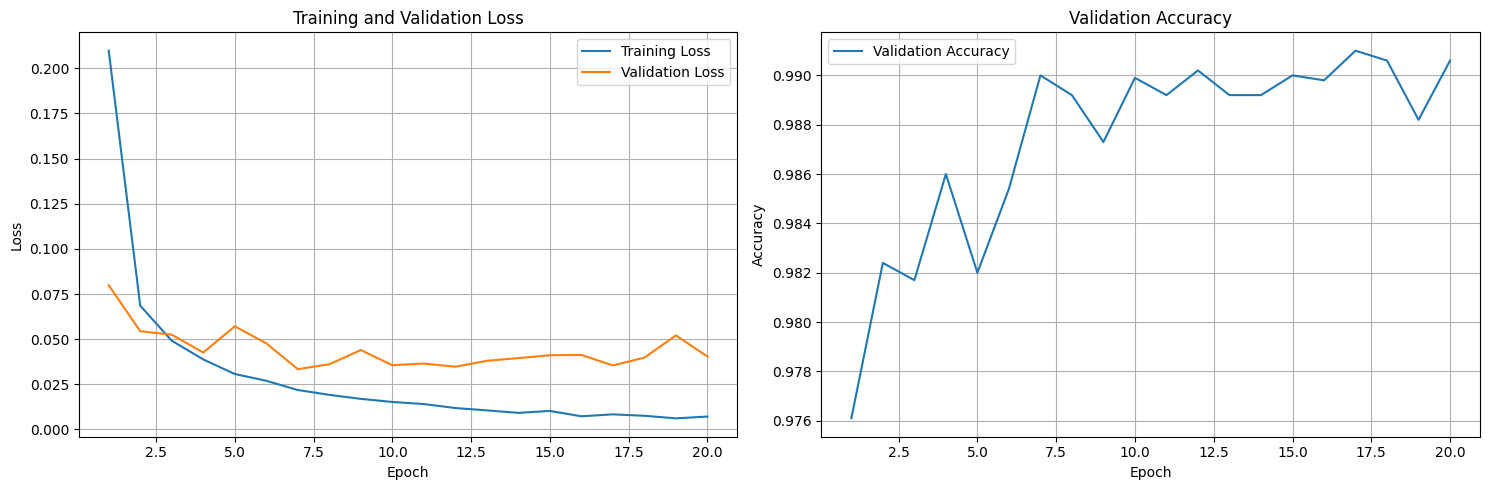

In [15]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 确保使用 GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 定义改进的 LeNet 模型
class ModifiedLeNet(nn.Module):
    def __init__(self):
        super(ModifiedLeNet, self).__init__()

        # 第一个卷积块
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 改为最大池化

        # 第二个卷积块
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 改为最大池化

        # 全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Xavier初始化
        self._initialize_weights()

    def forward(self, x):
        # 使用ReLU激活函数
        x = torch.relu(self.conv1(x))
        x = self.max_pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.max_pool2(x)

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)

# 设置随机种子以确保结果可重现
torch.manual_seed(42)

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# 加载MNIST数据集
print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Dataset loaded successfully!")

# 初始化模型、损失函数和优化器
model = ModifiedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# 评估函数
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

# 训练过程
epochs = 20
train_losses = []
test_losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}\n')

# 绘制结果
plt.figure(figsize=(15, 5))

# 训练损失和验证损失
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 验证准确率
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# 保存改进LeNet的结果
modified_train_losses = train_losses.copy()
modified_test_losses = test_losses.copy()
modified_accuracies = test_accuracies.copy()

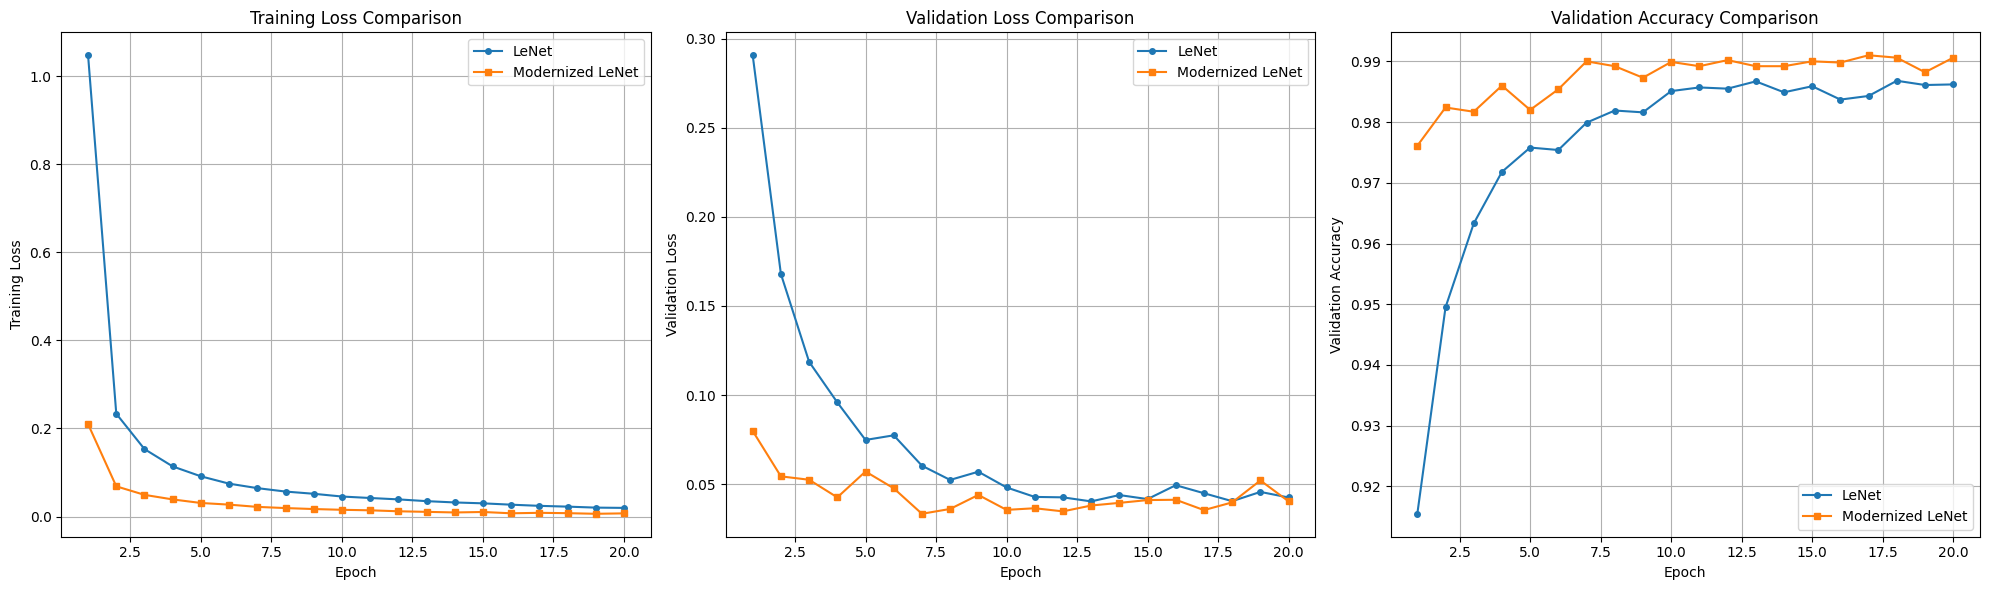


Final Performance Comparison:
Original LeNet - Final Validation Loss: 0.0425, Final Accuracy: 0.9862
Modified LeNet - Final Validation Loss: 0.0404, Final Accuracy: 0.9906


In [17]:
import matplotlib.pyplot as plt

# # 使用之前在block2中保存的原始LeNet结果
# lenet_train_losses = lenet_train_losses  # block2中保存的
# lenet_test_losses = lenet_test_losses    # block2中保存的
# lenet_accuracies = lenet_accuracies      # block2中保存的

# # 使用之前在block4中保存的改进LeNet结果
# modified_train_losses = modified_train_losses  # block4中保存的
# modified_test_losses = modified_test_losses    # block4中保存的
# modified_accuracies = modified_accuracies      # block4中保存的

# 创建一个包含三个子图的图表
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. 训练损失对比图
ax1.plot(range(1, epochs + 1), lenet_train_losses,
         label='LeNet', linestyle='-', marker='o', markersize=4)
ax1.plot(range(1, epochs + 1), modified_train_losses,
         label='Modernized LeNet', linestyle='-', marker='s', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Comparison')
ax1.grid(True)
ax1.legend()

# 2. 验证损失对比图
ax2.plot(range(1, epochs + 1), lenet_test_losses,
         label='LeNet', linestyle='-', marker='o', markersize=4)
ax2.plot(range(1, epochs + 1), modified_test_losses,
         label='Modernized LeNet', linestyle='-', marker='s', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss Comparison')
ax2.grid(True)
ax2.legend()

# 3. 验证准确率对比图
ax3.plot(range(1, epochs + 1), lenet_accuracies,
         label='LeNet', linestyle='-', marker='o', markersize=4)
ax3.plot(range(1, epochs + 1), modified_accuracies,
         label='Modernized LeNet', linestyle='-', marker='s', markersize=4)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Validation Accuracy')
ax3.set_title('Validation Accuracy Comparison')
ax3.grid(True)
ax3.legend()

# 调整布局
plt.tight_layout()
plt.show()

# 打印最终性能比较
print("\nFinal Performance Comparison:")
print(f"Original LeNet - Final Validation Loss: {lenet_test_losses[-1]:.4f}, "
      f"Final Accuracy: {lenet_accuracies[-1]:.4f}")
print(f"Modified LeNet - Final Validation Loss: {modified_test_losses[-1]:.4f}, "
      f"Final Accuracy: {modified_accuracies[-1]:.4f}")